# Small data and deep learning
This pratical session proposes to study several techniques to improve training performance in the challenging context where few data and resources are available.

# Introduction
Assume we are in a context where few "gold" labeled data are available for training, say $\mathcal{X}_{\text{train}}\triangleq\{(x_n,y_n)\}_{n\leq N_{\text{train}}}$, where $N_{\text{train}}$ is small. A large test set $\mathcal{X}_{\text{test}}$ is available. A large amount of unlabeled data, $\mathcal{X}_{\text{nolabel}}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |


If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset.)

In your final report, please keep the logs of each training procedure you used. We will only run this jupyter if we have some doubts on your implementation. 

__The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.__


To run your experiments, you can use the same local installation as for previous TPs, or otherwise https://colab.research.google.com/.

## Training set creation
__Question 1 (2 points) :__ Propose a dataloader that will only use the first 100 samples of the CIFAR-10 training set. 

*Hint* : You can modify the file located at https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py or use the information from https://pytorch.org/vision/stable/datasets.html

This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. The remaining samples correspond to $\mathcal{X}_{\text{nolabel}}$. The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

In [71]:
import torch
import torchvision
import pandas as pd
import numpy as np
import os

import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

In [72]:
import torch.utils.data as data_utils

indices = torch.arange(100)

In [73]:
CIFAR10_data_train = torchvision.datasets.CIFAR10("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz", 
                                          train=True,
                                          download=True,
                                          transform=transforms.ToTensor())

CIFAR10_data_train = data_utils.Subset(CIFAR10_data_train, indices)
trainloader = torch.utils.data.DataLoader(CIFAR10_data_train,
                                          batch_size=128,
                                          shuffle=True)


Files already downloaded and verified


In [74]:
CIFAR10_data_train

In [75]:
CIFAR10_data_test = torchvision.datasets.CIFAR10("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz", 
                                          train=False,
                                          download=True,
                                          transform=transforms.ToTensor())

CIFAR10_data_test = data_utils.Subset(CIFAR10_data_test, indices)
testloader = torch.utils.data.DataLoader(CIFAR10_data_test,
                                          batch_size=100,
                                          shuffle=True)

Files already downloaded and verified


In [76]:
testloader

## Testing procedure
__Question 2 (1.5 points) :__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

In [77]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

# Raw approach: the baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate schedule, i.e. how to decrease the learning rate as a function of the number of epochs. A possible schedule is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. Obviously, it is a different context for those researchers who had access to GPUs.

In [78]:
'''Some helper functions for PyTorch, including:
    - get_mean_and_std: calculate the mean and std value of dataset.
    - msr_init: net parameter initialization.
    - progress_bar: progress bar mimic xlua.progress.
'''
import os
import sys
import time
import math

import torch.nn as nn
import torch.nn.init as init


def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal(m.weight, std=1e-3)
            if m.bias:
                init.constant(m.bias, 0)

term_width = 1
# _, term_width = os.popen('stty size', 'r').read().split()
# term_width = int(term_width)

TOTAL_BAR_LENGTH = 15.
last_time = time.time()
begin_time = last_time
def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f

In [79]:

def train(epoch, net):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

def test(epoch, net, model):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        if model == "Resnet18": torch.save(state, './checkpoint/ckpt_R18.pth')
        if model == "EfficientNet": torch.save(state, './checkpoint/ckpt_EN.pth')
        if model == "EfficientNetB0": torch.save(state, './checkpoint/ckpt_ENB0.pth')
        best_acc = acc


In [80]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
lr = 1e-2


## ResNet architectures

__Question 3 (4 points) :__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ResNet-18 model, originally designed for the ImageNet dataset, can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint:* You can re-use the following code: https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

In [81]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


In [82]:
Resnet18 = ResNet18()
Resnet18 = Resnet18.to(device)
if device == 'cuda':
    Resnet18 = torch.nn.DataParallel(Resnet18)
    cudnn.benchmark = True

In [83]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Resnet18.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

for epoch in range(start_epoch, start_epoch+200):
    train(epoch, Resnet18)
    print("Train ^    Test v")
    test(epoch, Resnet18, "Resnet18")
    scheduler.step()


Epoch: 0
 [>..............]  Step: 425ms | Tot: 0ms | Loss: 2.554 | Acc: 4.000% (4/100) 1/1 
Train ^    Test v
 [>..............]  Step: 54ms | Tot: 0ms | Loss: 2.305 | Acc: 7.000% (7/100) 1/1 
Saving..

Epoch: 1
 [>..............]  Step: 235ms | Tot: 2ms | Loss: 2.065 | Acc: 31.000% (31/100) 1/1 
Train ^    Test v
 [>..............]  Step: 49ms | Tot: 0ms | Loss: 2.308 | Acc: 7.000% (7/100) 1/1 

Epoch: 2
 [>..............]  Step: 100ms | Tot: 0ms | Loss: 1.761 | Acc: 61.000% (61/100) 1/1 
Train ^    Test v
 [>..............]  Step: 43ms | Tot: 1ms | Loss: 2.316 | Acc: 9.000% (9/100) 1/1 
Saving..

Epoch: 3
 [>..............]  Step: 203ms | Tot: 1ms | Loss: 1.535 | Acc: 70.000% (70/100) 1/1 
Train ^    Test v
 [>..............]  Step: 44ms | Tot: 2ms | Loss: 2.328 | Acc: 10.000% (10/100) 1/1 
Saving..

Epoch: 4
 [>..............]  Step: 204ms | Tot: 0ms | Loss: 1.292 | Acc: 75.000% (75/100) 1/1 
Train ^    Test v
 [>..............]  Step: 43ms | Tot: 0ms | Loss: 2.344 | Acc: 10.000% 

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet 18  | 200 | 100.0 % | 19.0 % |

# Transfer learning

We propose to use pre-trained models on a classification task, in order to improve the results of our setting.

## ImageNet features

Now, we will use a model pre-trained on ImageNet and see how well it performs on CIFAR. A list of ImageNet pre-trained models is available on : https://pytorch.org/vision/stable/models.html

__Question 4 (3 points) :__ Pick a model from the list above, adapt it for CIFAR and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In [84]:
class Custom_EfficientNet(nn.Module):
  def __init__(self):
    super().__init__()
    base = torchvision.models.efficientnet_b0(pretrained = True, progress = True)
    self.base = nn.Sequential(*list(base.children())[:-1]) #remove last layer
    self.dropout = nn.Dropout()
    self.fc2 = nn.Linear(1280, 128)
    self.output = nn.Linear(128,10)

  def forward(self, x):
    x = self.base(x)
    x = self.dropout(x.view(-1, self.fc2.in_features))
    x = self.fc2(x)
    x = self.dropout(x)
    out = self.output(x)
    return out

In [85]:
# from https://pytorch.org/vision/stable/_modules/torchvision/models/efficientnet.html#efficientnet_b0
# https://pytorch.org/vision/stable/models.html
EfficientNet = Custom_EfficientNet()
EfficientNet = EfficientNet.to(device)
if device == 'cuda':
    EfficientNet = torch.nn.DataParallel(EfficientNet)
    cudnn.benchmark = True

In [86]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(EfficientNet.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

for epoch in range(start_epoch, start_epoch+200):
    train(epoch, EfficientNet)
    test(epoch, EfficientNet, "EfficientNet")
    scheduler.step()


Epoch: 0
 [>..............]  Step: 268ms | Tot: 2ms | Loss: 2.466 | Acc: 8.000% (8/100) 1/1 
 [>..............]  Step: 32ms | Tot: 3ms | Loss: 2.304 | Acc: 10.000% (10/100) 1/1 

Epoch: 1
 [>..............]  Step: 66ms | Tot: 2ms | Loss: 2.373 | Acc: 9.000% (9/100) 1/1 
 [>..............]  Step: 28ms | Tot: 1ms | Loss: 2.307 | Acc: 6.000% (6/100) 1/1 

Epoch: 2
 [>..............]  Step: 63ms | Tot: 0ms | Loss: 2.385 | Acc: 13.000% (13/100) 1/1 
 [>..............]  Step: 28ms | Tot: 0ms | Loss: 2.310 | Acc: 5.000% (5/100) 1/1 

Epoch: 3
 [>..............]  Step: 67ms | Tot: 0ms | Loss: 2.289 | Acc: 18.000% (18/100) 1/1 
 [>..............]  Step: 32ms | Tot: 0ms | Loss: 2.310 | Acc: 7.000% (7/100) 1/1 

Epoch: 4
 [>..............]  Step: 65ms | Tot: 0ms | Loss: 2.209 | Acc: 15.000% (15/100) 1/1 
 [>..............]  Step: 35ms | Tot: 2ms | Loss: 2.306 | Acc: 11.000% (11/100) 1/1 

Epoch: 5
 [>..............]  Step: 70ms | Tot: 0ms | Loss: 2.130 | Acc: 23.000% (23/100) 1/1 
 [>...........

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   EfficientNet  | 200 | 100.0 % | 23.0 % |

# Incorporating priors
Geometrical priors are appealing for image classification tasks. 
A color image $x$ can be seen as a function: $\mathbb{S}\rightarrow\mathbb{R}^3$, where $\mathbb{S} \subset \mathbb{R}^2$ is the image support.
Let us consider transformations $\mathcal{T}$ of possible inputs $x$. For instance, if an image had infinite support, a translation $\mathcal{T}_a$ of an image $x$ by a shift $a$ would lead to a new infinite-support image $\mathcal{T}_a(x)$, described at each pixel $u$ by :

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

__Question 5 (1.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

One of the main reasons there are issues with 32x32 images is the fact that the dimensions are inherently small. 

*   Translations: Picking a random subcrop of 32x32 pixels will be tiny and hold very little information. Lots of information lost can be avoided by fine-tuning the minimum size of the crop. 
*   Rotations: Is very hard to imagine all the rotations feasible in a small subset (100 samples). Additionally, naturally occuring cars or horses don't run upside down. 
*   Scaling: It is hard to scale to any larger size since the data would remain with the quality of a 32x32 granularity. Any smaller and we lose too valuable information. 
*   Color: Changing the color (gradient) of one pixel has a much bigger impact on the 32x32 images than on 256x256 (for example) since each pixel represents a larger area of the underlying object. Boats, planes usually have the same color schemas (blue water/sky) would create inconsistencies and make the predictions harrder. 


## Data augmentations

__Question 6 (3 points) :__ Propose a set of geometric transformations beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.
You can use tools from https://pytorch.org/vision/stable/transforms.html 

In [87]:
from torchvision.transforms import transforms
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [88]:
CIFAR10_data_train = torchvision.datasets.CIFAR10("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz", 
                                          train=True,
                                          download=True,
                                          transform=transform)

CIFAR10_data_train = data_utils.Subset(CIFAR10_data_train, indices)
trainloader = torch.utils.data.DataLoader(CIFAR10_data_train,
                                          batch_size=128,
                                          shuffle=True)


Files already downloaded and verified


In [89]:
CIFAR10_data_test = torchvision.datasets.CIFAR10("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz", 
                                          train=False,
                                          download=True,
                                          transform=transform_test)

CIFAR10_data_test = data_utils.Subset(CIFAR10_data_test, indices)
testloader = torch.utils.data.DataLoader(CIFAR10_data_test,
                                          batch_size=100,
                                          shuffle=True) 

Files already downloaded and verified


In [109]:
Resnet = ResNet18()
Resnet = Resnet.to(device)
if device == 'cuda':
    Resnet = torch.nn.DataParallel(Resnet)
    cudnn.benchmark = True

In [110]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Resnet.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

for epoch in range(start_epoch, start_epoch+200):
    train(epoch, Resnet)
    test(epoch, Resnet, "Resnet18")
    scheduler.step()


Epoch: 0
 [>..............]  Step: 7s41ms | Tot: 0ms | Loss: 2.458 | Acc: 14.000% (14/100) 1/1 
 [>..............]  Step: 59ms | Tot: 1ms | Loss: 2.305 | Acc: 8.000% (8/100) 1/1 

Epoch: 1
 [>..............]  Step: 120ms | Tot: 0ms | Loss: 2.304 | Acc: 17.000% (17/100) 1/1 
 [>..............]  Step: 50ms | Tot: 1ms | Loss: 2.307 | Acc: 8.000% (8/100) 1/1 

Epoch: 2
 [>..............]  Step: 113ms | Tot: 0ms | Loss: 2.172 | Acc: 21.000% (21/100) 1/1 
 [>..............]  Step: 49ms | Tot: 2ms | Loss: 2.311 | Acc: 13.000% (13/100) 1/1 

Epoch: 3
 [>..............]  Step: 106ms | Tot: 0ms | Loss: 2.182 | Acc: 20.000% (20/100) 1/1 
 [>..............]  Step: 48ms | Tot: 1ms | Loss: 2.316 | Acc: 10.000% (10/100) 1/1 

Epoch: 4
 [>..............]  Step: 107ms | Tot: 0ms | Loss: 2.191 | Acc: 21.000% (21/100) 1/1 
 [>..............]  Step: 46ms | Tot: 0ms | Loss: 2.321 | Acc: 10.000% (10/100) 1/1 

Epoch: 5
 [>..............]  Step: 109ms | Tot: 0ms | Loss: 2.024 | Acc: 26.000% (26/100) 1/1 
 [

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18  | 200 | 100.0 % | 23.0 % |

### transformations with EfficientNet

In [100]:
# from https://pytorch.org/vision/stable/_modules/torchvision/models/efficientnet.html#efficientnet_b0
# https://pytorch.org/vision/stable/models.html
EfficientNet = Custom_EfficientNet()
EfficientNet = EfficientNet.to(device)
if device == 'cuda':
    EfficientNet = torch.nn.DataParallel(EfficientNet)
    cudnn.benchmark = True

In [103]:
#running the same thing with EfficientNet
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(EfficientNet.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

for epoch in range(start_epoch, start_epoch+200):
    train(epoch, EfficientNet)
    test(epoch, EfficientNet, "EfficientNet")
    scheduler.step()


Epoch: 0
 [>..............]  Step: 36s460ms | Tot: 0ms | Loss: 0.145 | Acc: 97.000% (97/100) 1/1 
 [>..............]  Step: 48ms | Tot: 1ms | Loss: 3.160 | Acc: 29.000% (29/100) 1/1 

Epoch: 1
 [>..............]  Step: 99ms | Tot: 0ms | Loss: 0.078 | Acc: 99.000% (99/100) 1/1 
 [>..............]  Step: 44ms | Tot: 2ms | Loss: 3.177 | Acc: 29.000% (29/100) 1/1 

Epoch: 2
 [>..............]  Step: 94ms | Tot: 1ms | Loss: 0.064 | Acc: 100.000% (100/100) 1/1 
 [>..............]  Step: 40ms | Tot: 1ms | Loss: 3.159 | Acc: 29.000% (29/100) 1/1 

Epoch: 3
 [>..............]  Step: 93ms | Tot: 0ms | Loss: 0.074 | Acc: 99.000% (99/100) 1/1 
 [>..............]  Step: 37ms | Tot: 0ms | Loss: 3.164 | Acc: 30.000% (30/100) 1/1 

Epoch: 4
 [>..............]  Step: 89ms | Tot: 1ms | Loss: 0.080 | Acc: 99.000% (99/100) 1/1 
 [>..............]  Step: 44ms | Tot: 0ms | Loss: 3.168 | Acc: 30.000% (30/100) 1/1 

Epoch: 5
 [>..............]  Step: 85ms | Tot: 0ms | Loss: 0.076 | Acc: 98.000% (98/100) 1/1 

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   EfficientNet  | 200 | 100.0 % | 34.0 % |

# Conclusions

__Question 7 (5 points) :__ Write a short report explaining the pros and the cons of each method you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

We should look to the difference between ResNet and EfficientNet for this question.  \\
According to the authors of [ResNet](https://arxiv.org/pdf/1512.03385.pdf) , it is built with the following building block:

```
def forward(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    if self.downsample is not None:
       identity = self.downsample(x)

    out += identity
    out = self.relu(out)

    return out
```
This block showcases their innovation: passing the indentity function through the network. The helped with the previous model's degradation problem when approximating the "true" identity function.



In [111]:
data = [["ResNet18", 19],
        ["EfficientNet", 23], 
        ["Resnet + Transformations", 23],
        ["EfficientNet + Transformations", 34],
        ["Resnet Paper", 86.65],
        ["EfficientNet Paper", 98.9]]
df = pd.DataFrame(data, columns=["Model", "Testing Accuracy"])

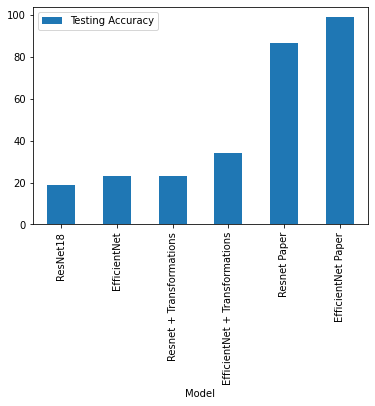

In [112]:
df.plot.bar(x="Model", y = "Testing Accuracy")

Looking at the [EfficientNet](https://paperswithcode.com/paper/efficientnet-rethinking-model-scaling-for) and [Resnet](https://paperswithcode.com/paper/deep-residual-learning-for-image-recognition) paper, we understand why it vastly outperformed our results. They trained on the full data set and used GPU support. 

However, thanks to the transformations applied, we can see that it has a significant and important impact on the model performance. 34% on the EfficientNet is something I am quite proud of.

# Weak supervision

__Bonus \[open\] question (up to 4 points) :__ Pick a weakly supervised method that will potentially use $\mathcal{X}_{\text{nolabel}}\cup\mathcal{X}_{\text{train}}$ to train a model (a subset of $\mathcal{X}_{\text{nolabel}}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.